# CHEM452 - Model Assessment with cross-validation

Here, we are going to implement K-fold cross-validation from scratch. Note that in the homeworks you will be asked to look through scikit-learn's documentation and figure out how to do this using some of their classes that automate many of these tasks. We are going to work with the melting point dataset again.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

dataset_name = "Solubility.csv"
df = pd.read_csv(dataset_name)
x = df[['MolLogP','NumHAcceptors','NumHDonors','NumAromaticRings']].values[:1000]
y = np.array(df[['Solubility']].values)[:1000]


## Cross-Validation from Scratch

Let's implement a logarithmic grid search with k-fold cross-validation with regularization from scratch.  

Note that there are good scikit-learn libraries available for k-fold cross validation here that you will use on the homework: https://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html.

There is also a specific grid search that incorporates cross-validation here https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.

Finally, there is a pre-packaged cross-validation scorer available here that can be used with most models in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html.  

In [ ]:
rmse_train_mean = [] #List to store mean RMSE on training set as function of regularization
rmse_train_std = [] #List to store variance of RMSE on training set as function of regularization
rmse_val_mean = [] #List to store mean RMSE on validation set as function of regularization
rmse_val_std = [] #List to store variance of RMSE on validation set as function of reglularization
cc_list = [] #List to record value of regularization to make plotting easier

size = len(x) #Compute how many datapoints are in the dataset
id_all = np.arange(size) #Create an array to hold id's corresponding to each data point
k_fold = 5 #number of folds in cross-validation

#Loop over different possible regularization (alpha) values that are log-spaced
#Note that a grid search in one dimension is just a for loop
#A grid search of many parameters becomes many nested for loops, which
#should be avoided for obvious computational cost reasons...

for cc in np.logspace(-3,3,7): #Loop in logspace

    model_tmp = SVR(C=cc) # adjust Ridge regularization hyperparameter alpha

    # k-fold cross validation
    rmse_train = np.zeros(k_fold) #Array to store individual train RMSE for each fold
    rmse_val = np.zeros(k_fold) #Array to store individual validation RMSE for each fold

    #This is a manual way to implement k-fold cross-validation that creates
    #the folds manually using the iterator ik and manually computing the fold size (int(size/k_fold))
    #In the homework you will use sklearn to simplify this with the KFold method

    #Also, note that I do not do any standard scaling here, whereas you should
    #incorporate this for best practice!

    for ik in range(k_fold):

        id_val = np.arange(ik*int(size/k_fold),(ik+1)*int(size/k_fold)) #Compute the list of ids for validation folds
        id_train = np.setdiff1d(id_all,id_val) #Compute list of ids for training folds
        x_train  = x[id_train] #Select training data
        y_train = y[id_train]
        x_val = x[id_val] #Select validation data
        y_val = y[id_val]

        model_tmp.fit(x_train,y_train) #fit the model

        #I'm manually computing these error metrics, but you could just as well use the sklearn metrics library
        rmse_train[ik] = np.sqrt(mean_squared_error(model_tmp.predict(x_train),y_train))
        rmse_val[ik] = np.sqrt(mean_squared_error(model_tmp.predict(x_val),y_val))


    rmse_train_mean.append(np.mean(rmse_train))
    rmse_train_std.append(np.std(rmse_train)) #Compute variance of training rmse
    rmse_val_mean.append(np.mean(rmse_val))
    rmse_val_std.append(np.std(rmse_val)) #Compute variance of validation rmse
    cc_list.append(cc)

rmse_train_mean = np.array(rmse_train_mean)
rmse_train_std = np.array(rmse_train_std)
rmse_val_mean = np.array(rmse_val_mean)
rmse_val_std = np.array(rmse_val_std)
cc_list = np.array(cc_list)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Let's plot the cross-validated performance of the regression as a function of the regularization weight value.  The results are not dramatic for this dataset, but there is certainly a minimum in the validation error reached at around 2.5! The training error exhibits no such minimum.

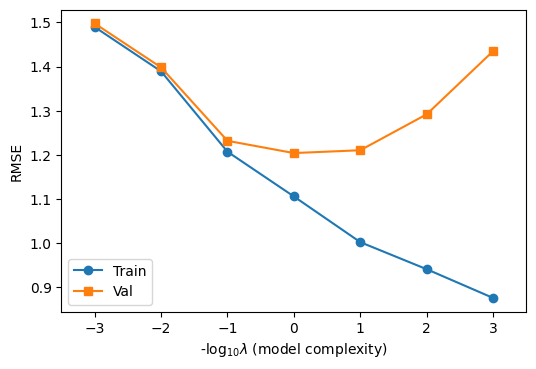

In [ ]:
plt.figure(dpi=100)
#The error bars are pretty large, so I'm just going to show the mean in this demonstration
#But you can use these commands to do error bar plots!

#plt.errorbar(np.linspace(-5,5,41),rmse_train_mean,yerr=rmse_train_std,marker='o',label='Train')
#plt.errorbar(np.linspace(-5,5,41),rmse_val_mean,yerr=rmse_val_std,marker='s',label='Val')
plt.plot(np.linspace(-3,3,7),rmse_train_mean,marker='o',label='Train')
plt.plot(np.linspace(-3,3,7),rmse_val_mean,marker='s',label='Val')
plt.xlim(-3.5,3.5)
plt.ylabel('RMSE')
plt.xlabel('-log$_{10}\lambda$ (model complexity)')
plt.legend();

# Making Pipelines in Scikit-learn

Is there a shorter way to combine a standard scaler and a regression function instead of doing it all manually as in the Lecture 4 example? Yep - pipelines. It is also common to add dimensionality reduction into the pipeline - we will cover dimensionality reduction later in the class.

0.17274242326314937


Text(0, 0.5, 'Predict')

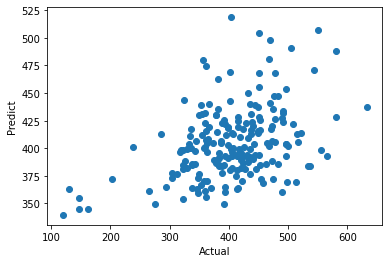

In [ ]:
from sklearn.pipeline import Pipeline

#Make a pipeline with standard scaling and linear regression chained together
pipe = Pipeline([('scaler', StandardScaler()), ('lr',LinearRegression())])
pipe.fit(x,y) #Fit the pipeline
y_lr = pipe.predict(x) #Predict using the pipeline
print(pipe.score(x,y)) #Score defaults to R2 for linear regression
plt.scatter(y,y_lr) #Plot predicted vs actual ground truth melting points
plt.xlabel('Actual')
plt.ylabel('Predict')

## Bootstrapping

scikit-learn also has a cross-validation method that uses bootstrapping in sklearn.cross_validation.Bootstrap.  Here we will just do vanilla bootstrapping with the melting point dataset to see how it works.

In [ ]:
from sklearn.utils import resample

#This simple command would generate 10 bootstrapped samples drawn from the
#distributions of x and y. These bootstrapped samples could be used to compute
#variance estimates.
x_res,y_res = resample(x,y,n_samples=10,random_state=99)
print(x_res)
print(y_res)

[[11.35701135  3.11979595 18.        ]
 [22.69716356  5.5797044  24.        ]
 [11.47605184  2.37126491 21.        ]
 [33.38087304  8.77946337 33.        ]
 [19.26557826  7.34644036 20.        ]
 [21.52347245  5.22811698 34.        ]
 [37.67436582  2.52916588 33.        ]
 [11.35701135  3.11979595 18.        ]
 [ 8.45570461  5.72838026 19.        ]
 [22.69716356  5.5797044  24.        ]]
[[433.15]
 [354.15]
 [323.15]
 [356.65]
 [435.15]
 [391.15]
 [492.15]
 [433.15]
 [387.15]
 [354.15]]
